In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
import sqlite3
import csv
import warnings
warnings.filterwarnings("ignore")

In [88]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [5]:
%%time
df=pd.read_csv('Train.csv',encoding='utf-8',engine='python',error_bad_lines=False)

Wall time: 3min 29s


In [6]:
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [7]:
dup=df[df.duplicated(['Title','Body','Tags'])]

In [8]:
print('{} % of values are duplicates'.format((len(dup)/len(df))*100))

30.29204392632323 % of values are duplicates


In [10]:
df=df.drop(dup['Id']) #Dropping duplicates

In [11]:
print('Number of Questions:',len(df))

Number of Questions: 4206314


In [12]:
df.isnull().sum()

Id       0
Title    0
Body     0
Tags     7
dtype: int64

In [13]:
df.dropna(inplace=True)

In [14]:
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [16]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tags = vectorizer.fit_transform(df['Tags'])
tag = vectorizer.get_feature_names()

In [18]:
print("Number of data points :", tags.shape[0])
print("Number of unique tags :", tags.shape[1])

Number of data points : 4206307
Number of unique tags : 41086


In [25]:
freqs = tags.sum(axis=0).A1 #a1 flattens the summed array ->column wise sum gives freq of tags
result = dict(zip(tag, freqs))

In [26]:
df_tags=pd.DataFrame(list(result.items()), columns=['Tag', 'freq'])

In [27]:
df_tags.head()

,Tag,freq
0,.a,16
1,.app,41
2,.asp.net-mvc,1
3,.aspxauth,17
4,.bash-profile,137


In [53]:
tag_df_sorted = df_tags.sort_values(['freq'], ascending=False)
tag_counts = tag_df_sorted['freq'].values

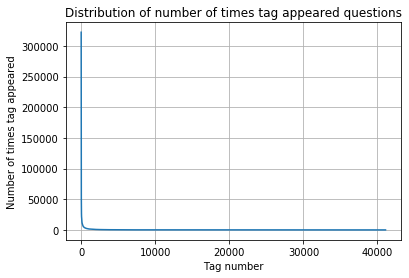

In [54]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

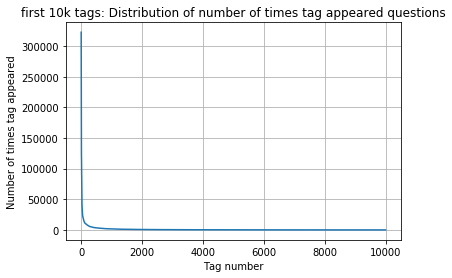

In [148]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

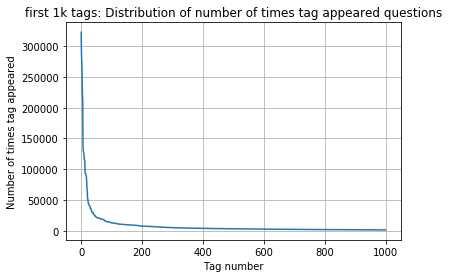

In [149]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

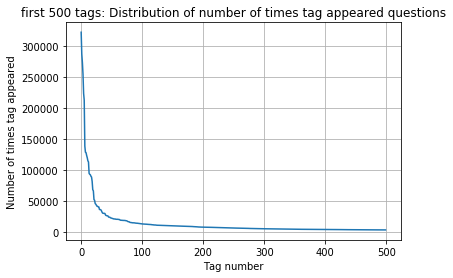

In [150]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

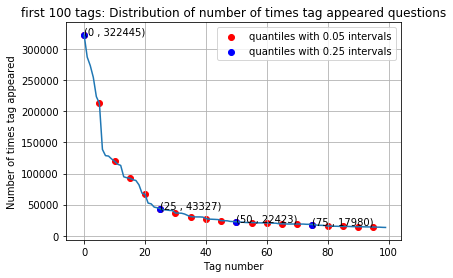

In [55]:
plt.plot(tag_counts[0:100])
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='r', label="quantiles with 0.05 intervals")
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='b', label = "quantiles with 0.25 intervals")
for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")

plt.legend()
plt.show()


In [56]:
b10k = df_tags[df_tags.freq>10000].Tag
print ('{} Tags are used more than 10000 times'.format(len(b10k)))
b100k =df_tags[df_tags.freq>100000].Tag
print ('{} Tags are used more than 100000 times'.format(len(b100k)))

151 Tags are used more than 10000 times
13 Tags are used more than 100000 times


In [57]:
tag_q_count=tags.sum(axis=1).A1 #row wise sum = total tags in a particular question


In [58]:
print( "Maximum number of tags per question: %d"%max(tag_q_count))
print( "Minimum number of tags per question: %d"%min(tag_q_count))

Maximum number of tags per question: 5
Minimum number of tags per question: 1


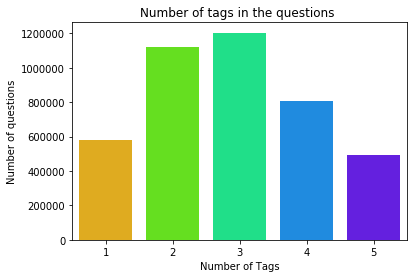

In [59]:
sns.countplot(tag_q_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

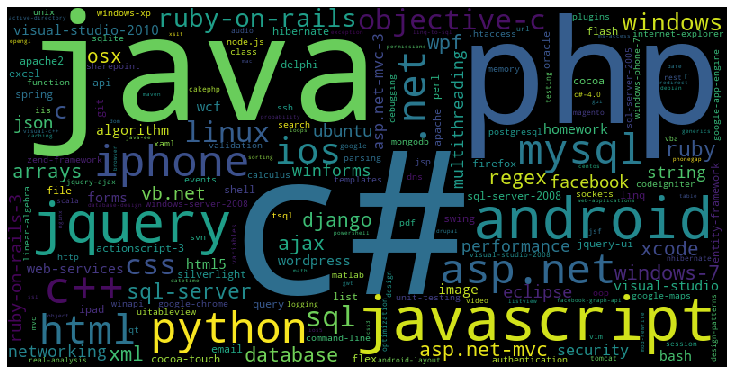

In [51]:
from wordcloud import WordCloud
from datetime import datetime

wordcloud = WordCloud(background_color='black',width=800,height=400,).generate_from_frequencies(result)
fig = plt.figure(figsize=(10,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

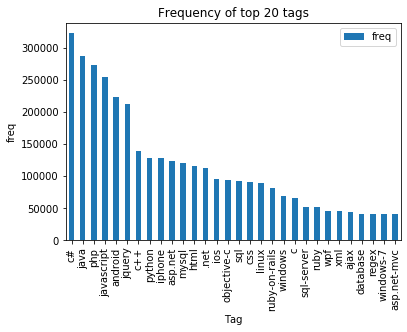

In [60]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tag'])
plt.xlabel('Tag')
plt.ylabel('freq')
plt.show()

In [61]:
data=df[:500000] #Taking .5m points
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [62]:
def remove_html(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [174]:
def preprocess(row,i):
    
    
    num,title, question, tags =row[0],row[1], row[2], row[3]
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=remove_html(question.encode('utf-8'))
    title=title.encode('utf-8')
    question=str(title)+" "+str(title)+" "+str(title)+" "" "+str(question) #3x question
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    if(i%100000==0):
        print((i/500000)*100,'% Processing (',i,'th value)')
        print('--'*60)
    r=[]
    r.append(num)
    r.append(title)
    r.append(question)
    r.append(tags)
    
    return r


In [180]:
%%time
l=[]
for i in range(500000):
    r=preprocess(list(data.iloc[i]),i)
    l.append(r)

0.0 % Processing ( 0 th value)
------------------------------------------------------------------------------------------------------------------------
20.0 % Processing ( 100000 th value)
------------------------------------------------------------------------------------------------------------------------
40.0 % Processing ( 200000 th value)
------------------------------------------------------------------------------------------------------------------------
60.0 % Processing ( 300000 th value)
------------------------------------------------------------------------------------------------------------------------
80.0 % Processing ( 400000 th value)
------------------------------------------------------------------------------------------------------------------------
Wall time: 16min 28s


In [181]:
cols=['Id','title','question','tags']
df_p=pd.DataFrame(l,columns=cols)

In [63]:
df_p.head()

,Unnamed: 0,Id,title,question,tags
0,0,1,b'How to check if an uploaded file is an image...,check upload file imag without mime type check...,php image-processing file-upload upload mime-t...
1,1,2,b'How can I prevent firefox from closing when ...,prevent firefox close press ctrl prevent firef...,firefox
2,2,3,b'R Error Invalid type (list) for variable',error invalid type list variabl error invalid ...,r matlab machine-learning
3,3,4,b'How do I replace special characters in a URL?',replac special charact url replac special char...,c# url encoding
4,4,5,b'How to modify whois contact details?',modifi whoi contact detail modifi whoi contact...,php api file-get-contents


In [195]:
#df_p.to_csv('preprocessed_data.csv')

In [67]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(df_p['tags'])
multilabel_y.shape

(500000, 30438)

In [75]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [76]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df_p.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

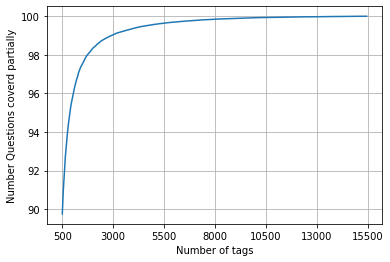

with  5500 tags we are covering  99.048 % of questions
with  500 tags we are covering  89.757 % of questions
with  600 tags we are covering  90.983 % of questions
with  700 tags we are covering  91.816 % of questions
with  1500 tags we are covering  95.768 % of questions
with  2000 tags we are covering  96.873 % of questions


In [81]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")
print("with ",600,"tags we are covering ",questions_explained[1],"% of questions")
print("with ",700,"tags we are covering ",questions_explained[2],"% of questions")
print("with ",1500,"tags we are covering ",questions_explained[10],"% of questions")
print("with ",2000,"tags we are covering ",questions_explained[15],"% of questions")

In [82]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 51216 out of  500000


In [83]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 30438
number of tags taken : 500 ( 1.6426834877455812 %)


In [84]:
total_size=df_p.shape[0]
train_size=int(0.80*total_size)

x_train=df_p.head(train_size)
x_test=df_p.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [85]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [86]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2",tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:29.925927


In [87]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 91398) Y : (400000, 500)
Dimensions of test data X: (100000, 91398) Y: (100000, 500)


In [98]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.3f}, Recall: {:.3f}, F1-measure: {:.3f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.3f}, Recall: {:.3f}, F1-measure: {:.3f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23547
Hamming loss  0.00279908
Micro-average quality numbers
Precision: 0.726, Recall: 0.349, F1-measure: 0.471
Macro-average quality numbers
Precision: 0.546, Recall: 0.267, F1-measure: 0.343
              precision    recall  f1-score   support

           0       0.65      0.25      0.36      7749
           1       0.82      0.47      0.59      6744
           2       0.86      0.54      0.66      6614
           3       0.76      0.43      0.55      6091
           4       0.95      0.74      0.83      5331
           5       0.88      0.64      0.74      5233
           6       0.71      0.32      0.44      3308
           7       0.89      0.62      0.73      3090
           8       0.74      0.41      0.53      3132
           9       0.82      0.41      0.55      2973
          10       0.87      0.62      0.73      2786
          11       0.55      0.20      0.29      2775
          12       0.61      0.12      0.21      2781
          13       0.60      0.27    

In [92]:
from sklearn.linear_model import LogisticRegression

start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.25085
Hamming loss  0.0027307
Micro-average quality numbers
Precision: 0.7169, Recall: 0.3906, F1-measure: 0.5056
Macro-average quality numbers
Precision: 0.5637, Recall: 0.3110, F1-measure: 0.3858
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      7749
           1       0.81      0.51      0.62      6744
           2       0.85      0.58      0.69      6614
           3       0.75      0.47      0.58      6091
           4       0.95      0.80      0.87      5331
           5       0.88      0.67      0.76      5233
           6       0.71      0.39      0.50      3308
           7       0.88      0.66      0.75      3090
           8       0.73      0.46      0.56      3132
           9       0.81      0.46      0.58      2973
          10       0.86      0.65      0.74      2786
          11       0.58      0.24      0.34      2775
          12       0.60      0.15      0.24      2781
          13       0.59      0.3

In [101]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.3f}, Recall: {:.3f}, F1-measure: {:.3f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.3f}, Recall: {:.3f}, F1-measure: {:.3f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2169
Hamming loss  0.0028615
Micro-average quality numbers
Precision: 0.833, Recall: 0.250, F1-measure: 0.384
Macro-average quality numbers
Precision: 0.263, Recall: 0.154, F1-measure: 0.186
              precision    recall  f1-score   support

           0       0.62      0.02      0.05      7749
           1       0.83      0.40      0.54      6744
           2       0.85      0.51      0.64      6614
           3       0.85      0.34      0.48      6091
           4       0.94      0.64      0.76      5331
           5       0.89      0.61      0.72      5233
           6       0.83      0.10      0.17      3308
           7       0.91      0.58      0.71      3090
           8       0.86      0.32      0.47      3132
           9       0.86      0.33      0.47      2973
          10       0.87      0.61      0.72      2786
          11       0.00      0.00      0.00      2775
          12       0.00      0.00      0.00      2781
          13       0.66      0.23      

In [104]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Featurization", "alpha",'Loss','Micro F1 Score']
x.add_row(['OneVsRest+SGD Classifier', "Tf-idf",0.00001,"log",0.471])
x.add_row(['OneVsRest+Linear Regression', "Tf-idf",0.0001,"log",0.5056])
x.add_row(['OneVsRest+SGD Classifier', "Tf-idf",0.0001,"hinge",0.384])
print(x)

+-----------------------------+---------------+--------+-------+----------------+
|            Model            | Featurization | alpha  |  Loss | Micro F1 Score |
+-----------------------------+---------------+--------+-------+----------------+
|   OneVsRest+SGD Classifier  |     Tf-idf    | 1e-05  |  log  |     0.471      |
| OneVsRest+Linear Regression |     Tf-idf    | 0.0001 |  log  |     0.5056     |
|   OneVsRest+SGD Classifier  |     Tf-idf    | 0.0001 | hinge |     0.384      |
+-----------------------------+---------------+--------+-------+----------------+
